In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive
numpyro.set_host_device_count(10)

rng = random.PRNGKey(2023)


In [208]:
def func(x, y):
    # needs to be strong function of x and week function of y
    return x**2 - 2 * y + 3

In [209]:
rng, *key = random.split(rng, 4)

num_obs = 50
a = -5.0
b = 0.5
sigma_y = 0.2

shape = (num_obs,)
x = random.normal(key[0], shape=shape)
mu_y = a + b * x
y = mu_y + sigma_y * random.normal(key[1], shape=shape)

z = func(x, y)
sigma_z = 0.01
z_obs = z + sigma_z * random.normal(key[2], shape=shape)

Text(0, 0.5, 'y')

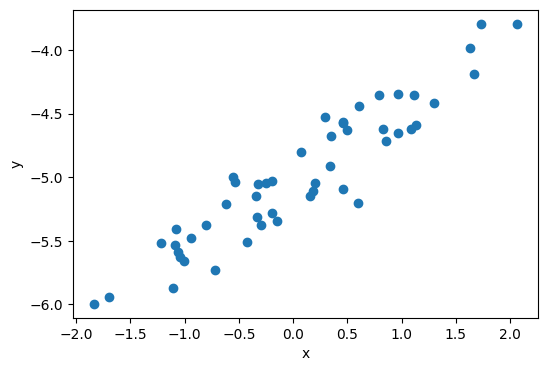

In [210]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y, "o")
ax.set_xlabel("x")
ax.set_ylabel("y")

Text(0.5, 0, 'y')

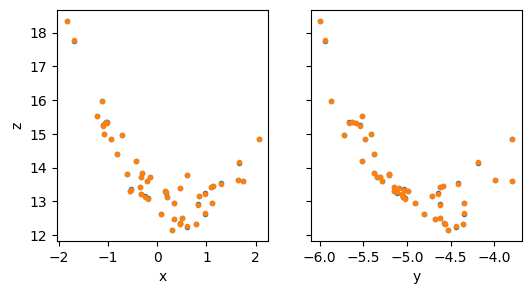

In [211]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
ax = axes[0]
ax.plot(x, z, ".")
ax.errorbar(x, z_obs, yerr=sigma_z, fmt=".")
ax.set_xlabel("x")
ax.set_ylabel("z")

ax = axes[1]
ax.plot(y, z, ".")
ax.errorbar(y, z_obs, yerr=sigma_z, fmt=".")
ax.set_xlabel("y")

In [212]:
def simple_model(z=None):
    x = numpyro.sample("x", dist.Normal(0., 2.), sample_shape=shape)
    y = numpyro.sample("y", dist.Normal(-5., 2.), sample_shape=shape)
    
    numpyro.sample("z", dist.Normal(func(x, y), sigma_z), obs=z)

In [213]:
sampler = NUTS(simple_model)
mcmc = MCMC(sampler, num_warmup=500, num_samples=1000, num_chains=10)

In [214]:
rng, key = random.split(rng)
mcmc.run(key, z=z_obs)
mcmc.print_summary()

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      x[0]      0.08      1.22      0.11     -1.80      2.15    212.19      1.03
      x[1]     -0.08      1.42     -0.13     -2.35      2.09    156.72      1.08
      x[2]      0.07      1.33      0.06     -1.91      2.29    169.48      1.05
      x[3]     -0.13      1.66     -0.14     -2.69      2.46    169.87      1.04
      x[4]      0.10      1.13      0.07     -1.74      1.93    194.80      1.06
      x[5]     -0.08      1.26     -0.18     -1.88      2.11     98.21      1.10
      x[6]      0.09      1.17      0.14     -1.82      1.91    183.09      1.05
      x[7]     -0.15      1.26     -0.16     -2.33      1.75    162.45      1.05
      x[8]      0.10      1.19      0.10     -1.81      2.09    161.56      1.06
      x[9]     -0.02      1.24     -0.03     -2.09      1.92    200.93      1.06
     x[10]     -0.05      1.34     -0.03     -2.29      1.99    222.62      1.05
     x[11]     -0.06      1

In [215]:
samples_simple = mcmc.get_samples()

In [216]:
rng, key = random.split(rng)
predictive = Predictive(simple_model, samples_simple)
pred_simple = predictive(key)

In [217]:
def hierarchical_model(z=None):
    a = numpyro.sample("a", dist.Normal(-5., 1.))
    b = numpyro.sample("b", dist.Normal(0., 1.))
    x = numpyro.sample("x", dist.Normal(0., 5.), sample_shape=shape)
    _y = numpyro.sample("_y", dist.Normal(), sample_shape=shape)
    
    mu_y = a + b * x
    y = numpyro.deterministic("y", mu_y + sigma_y * _y)

    numpyro.sample("z", dist.Normal(func(x, y), sigma_z), obs=z)

In [218]:
sampler = NUTS(hierarchical_model)
mcmc = MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=10)

In [219]:
rng, key = random.split(rng)
mcmc.run(key, z=z_obs)
mcmc.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     _y[0]     -0.26      1.02     -0.28     -2.03      1.35   1361.43      1.01
     _y[1]     -0.08      1.01     -0.06     -1.74      1.59   1318.70      1.01
     _y[2]     -0.08      0.98     -0.07     -1.68      1.55   1648.19      1.01
     _y[3]     -0.10      1.00     -0.11     -1.87      1.46   1405.40      1.01
     _y[4]      0.41      0.63      0.31     -0.56      1.38    917.88      1.01
     _y[5]     -0.34      1.01     -0.35     -2.01      1.21   1341.64      1.01
     _y[6]      1.10      0.50      1.06      0.29      1.92    372.95      1.03
     _y[7]     -0.23      1.04     -0.21     -1.95      1.49   1222.21      1.01
     _y[8]     -0.28      0.99     -0.29     -1.96      1.26   1417.54      1.00
     _y[9]     -0.19      1.02     -0.18     -1.98      1.39   1430.78      1.01
    _y[10]     -0.13      1.00     -0.12     -1.80      1.48   1559.82      1.01
    _y[11]      0.91      0

In [220]:
samples_hbm = mcmc.get_samples()

In [221]:
rng, key = random.split(rng)
predictive = Predictive(hierarchical_model, samples_hbm)
pred_hbm = predictive(key)

In [222]:
z_simple = (pred_simple["z"] - z_obs) / sigma_z
z_hbm = (pred_hbm["z"] - z_obs) / sigma_z

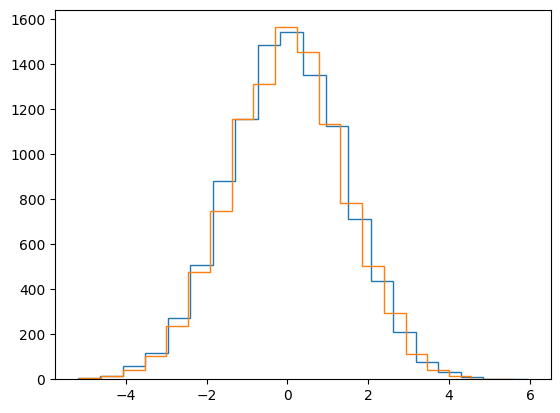

In [223]:
histtype = "step"
bins = 20
fig, ax = plt.subplots()
ax.hist(z_simple[::50].ravel(), bins=bins, histtype=histtype)
ax.hist(z_hbm[::50].ravel(), bins=bins, histtype=histtype);

Text(0, 0.5, 'y')

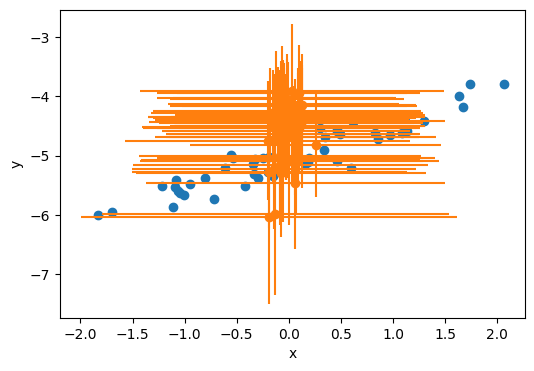

In [224]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y, "o")

ax.errorbar(
    samples_simple["x"].mean(0),
    samples_simple["y"].mean(0),
    xerr=samples_simple["x"].std(0),
    yerr=samples_simple["y"].std(0),
    fmt="o",
)
ax.set_xlabel("x")
ax.set_ylabel("y")

Text(0, 0.5, 'y')

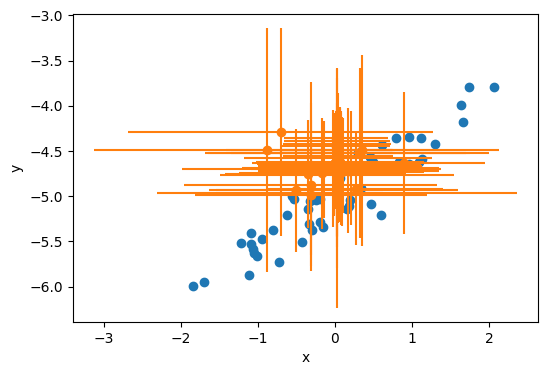

In [225]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y, "o")

ax.errorbar(
    samples_hbm["x"].mean(0),
    samples_hbm["y"].mean(0),
    xerr=samples_hbm["x"].std(0),
    yerr=samples_hbm["y"].std(0),
    fmt="o",
)
ax.set_xlabel("x")
ax.set_ylabel("y")